# 📈 💸 Time Series

## ℹ️ Readme

* ✍️ This challenge was written by [davydw](https://github.com/davydw)
* 🎯 The goal is to predict Apple Stock Price in the future using <font color="red">AR</font><font color="green">I</font><font color="blue">MA</font> model
* 🚓 It is designed only for students of `Le Wagon - Batch 1191 - Tokyo` and cannot be reproduced without davydw's authorization. Indeed, he is no longer working as a full time employee at Le Wagon. Hence, the latter cannot claim and publish this recap on their learning platform `Kitt` without his consent.


## 📚 Libraries

🎁 We have already imported all the functions you need from `statsmodels` and `pmdarima` here!

In [1]:
# DATA MANIPULATION
import pandas as pd
import numpy as np
import datetime

# DATA VISUALISATION
import matplotlib.pyplot as plt
import seaborn as sns

# STATSMODELS = TIME SERIES ANALYSIS
## DECOMPOSITION 
from statsmodels.tsa.seasonal import seasonal_decompose
## STATIONARITY ANALYSIS - HOW MANY ORDERS OF DIFFERENCING
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
## ACF AND PACF
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
## ARIMA / SARIMA
from statsmodels.tsa.arima.model import ARIMA 
## STATS GRIDSEARCH
import pmdarima as pm
## PLOT PREDICTION
from statsmodels.graphics.tsaplots import plot_predict

## ⚒️ Utils

In [2]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show;

## 👨🏻‍🏫 Box Jenkins Method

<img src="https://wagon-public-datasets.s3.amazonaws.com/data-science-images/lectures/machine-learning/time_serie_process_overview.jpg">

## (0) VISUALIZE

### (0.1) `AAPL` (1985-2023)

📈 [Apple Stock Price since 1985](https://finance.yahoo.com/quote/AAPL/history?period1=345427200&period2=1677715200&interval=1mo&filter=history&frequency=1mo&includeAdjustedClose=true) - *Source: Yahoo Finance*

<img src="https://github.com/davydw/public-pictures/blob/main/data-illustrations/yahoo_finance_tuto_aapl_stock_price.png?raw=true" height = 200 width = 600 align = "left">

In [3]:
# LOADING THE DATA
df = pd.read_csv('AAPL_monthly_yahoo_1985_2023.csv')
print(df.shape)

(459, 7)


In [4]:
df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1985-01-01,0.130022,0.138951,0.124442,0.129464,0.100589,6366416000
1,1985-02-01,0.129464,0.137277,0.110491,0.110491,0.085847,4733388800
2,1985-03-01,0.110491,0.116071,0.092634,0.098772,0.076742,4615587200


In [5]:
df.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume
456,2023-01-01,130.279999,147.229996,124.169998,144.289993,144.070023,1443218300
457,2023-02-01,143.970001,157.380005,141.320007,147.410004,147.185272,1307127200
458,2023-03-01,146.830002,147.229996,145.009995,145.309998,145.309998,55387700


In [6]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

❓ Convert the `Date` column into a `datetime` format and use it as the index of your DataFrame

👉 Let's focus on the `Close` values

<details>
    <summary><i>Hint</i></summary>

* <a href="https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html">pandas.to_datetime</a>
    * <i>infer_datetime_format</i>
        
</details>
        


In [7]:
df["Date"] = pd.to_datetime(df["Date"], infer_datetime_format=True)
df = df[["Date","Close"]]

In [8]:
df.head()

,Date,Close
0,1985-01-01,0.129464
1,1985-02-01,0.110491
2,1985-03-01,0.098772
3,1985-04-01,0.094866
4,1985-05-01,0.077567


### (0.2) First glimpse

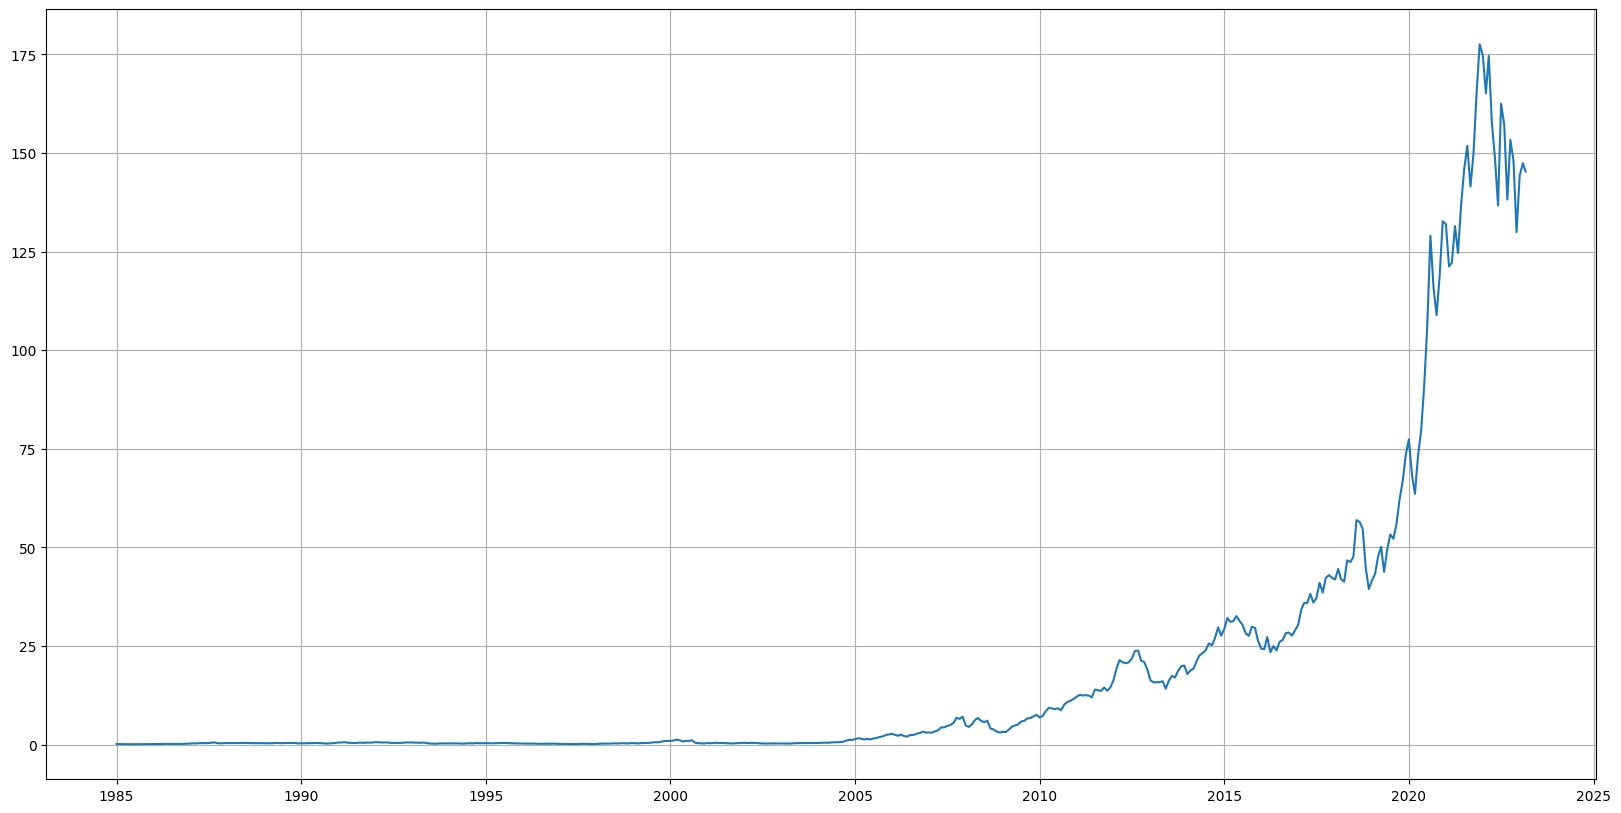

In [9]:
plt.figure(figsize=(20,10))
plt.plot(df["Date"],df["Close"])
plt.grid()
plt.show;

### (0.3) Linearizing

❓ What function could you use to linearize this Time Series? Linearize it.

In [10]:
train_size = 0.6
index = round(train_size*df.shape[0])

df_train = df.iloc[:index]
df_test = df.iloc[index:]

from sklearn.linear_model import LogisticRegression
log_df = np.log(df.drop(columns=['Date']))
log_df['Date'] = df[['Date']]

❓ Plot side-by-side the original TimeSeries and the Linearized Series

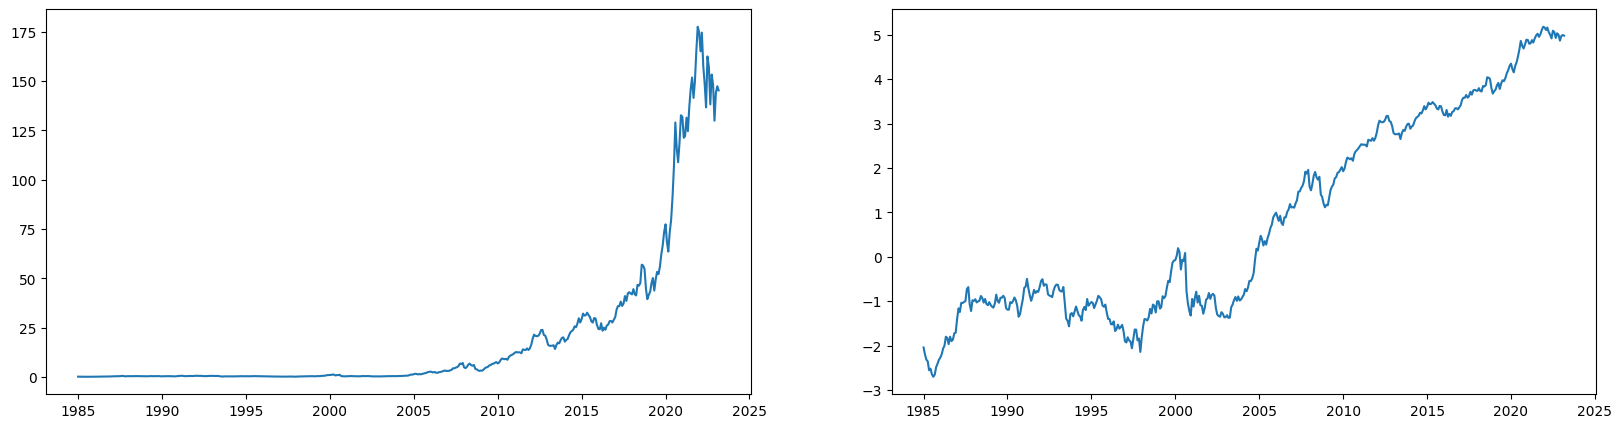

In [11]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.plot(df['Date'], df['Close'])
plt.subplot(1, 2, 2)
plt.plot(df['Date'], log_df['Close'])

👆 **Warnings**

* Time Series with negative values can't be decomposed multiplicatively...
* Apple stock price started skyrocketing after 2009...
* If you read a bit about Financial News, Apple proceeded to a stock split:
    - [Investopedia - Stocksplit](https://www.investopedia.com/terms/s/stocksplit.asp)
    - [Forbes 2020/07/31 - Apple announces a 4-for-1 split](https://www.forbes.com/sites/lcarrel/2020/07/31/apple-announces-4-for-1-stock-split-to-bring-in-new-investors/?sh=626f2e755401)

🎁 Run the following cells to remove data before 2020 and use the dates as the indexes of the TimeSeries.

In [12]:
date_after = datetime.date(2020, 1, 1)
date_after

datetime.date(2020, 1, 1)

In [13]:
log_df["Date"] = pd.to_datetime(log_df["Date"], infer_datetime_format=True)

In [14]:
df = df[df.Date.dt.date > date_after]
df.head(5)

,Date,Close
421,2020-02-01,68.339996
422,2020-03-01,63.572498
423,2020-04-01,73.449997
424,2020-05-01,79.485001
425,2020-06-01,91.199997


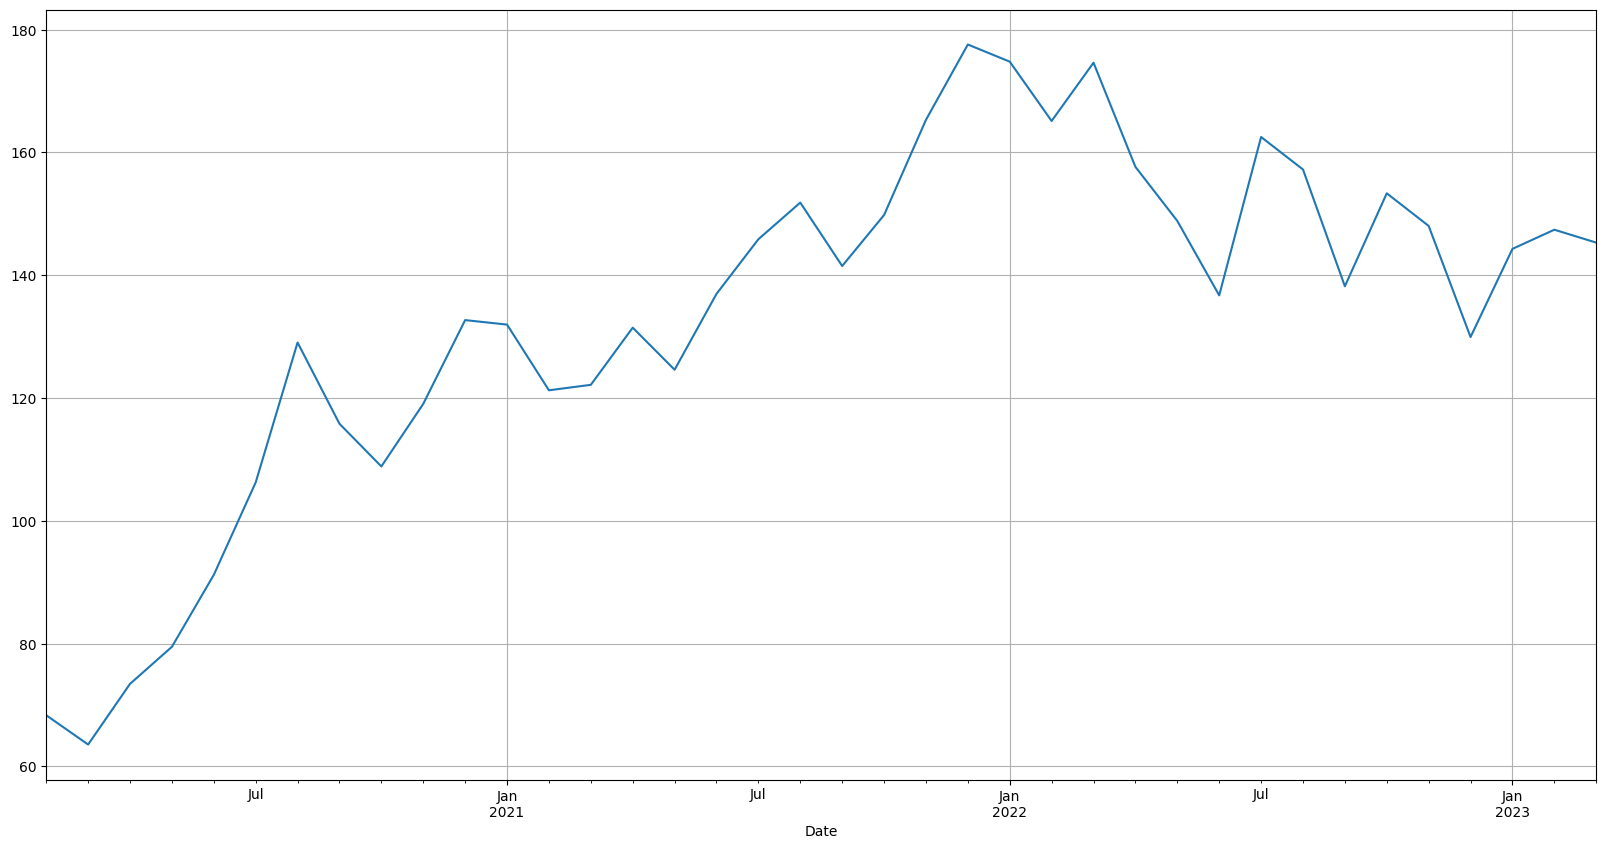

In [15]:
df.set_index("Date", inplace = True)
df.sort_index(inplace=True)

plt.figure(figsize=(20,10))
df["Close"].plot()
plt.grid()
plt.show();

In [16]:
log_df

,Close,Date
0,-2.044352,1985-01-01
1,-2.202821,1985-02-01
2,-2.314941,1985-03-01
3,-2.355290,1985-04-01
4,-2.556613,1985-05-01
...,...,...
454,4.997415,2022-11-01
455,4.866996,2022-12-01
456,4.971825,2023-01-01
457,4.993218,2023-02-01


In [17]:
log_df = log_df[log_df.Date.dt.date > date_after]

In [18]:
log_df.set_index("Date", inplace = True)
log_df.sort_index(inplace=True)

## (1) DECOMPOSE

### (1.1) Decomposition the "original" Time Series

❓ Decompose the original Time Series using `seasonal_decompose` additively and multiplicatively.

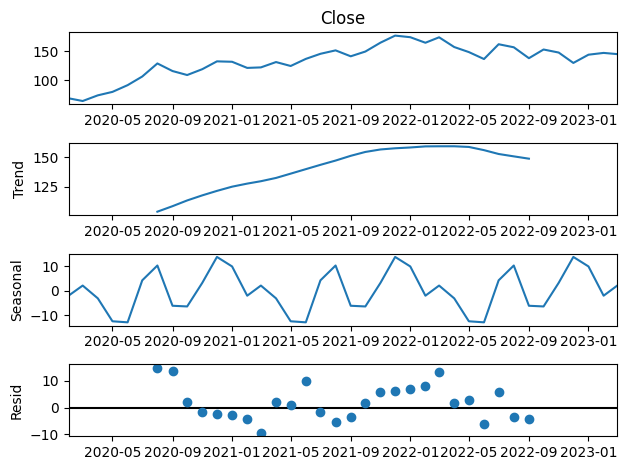

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_add = seasonal_decompose(df['Close'], model='additive')
result_add.plot();

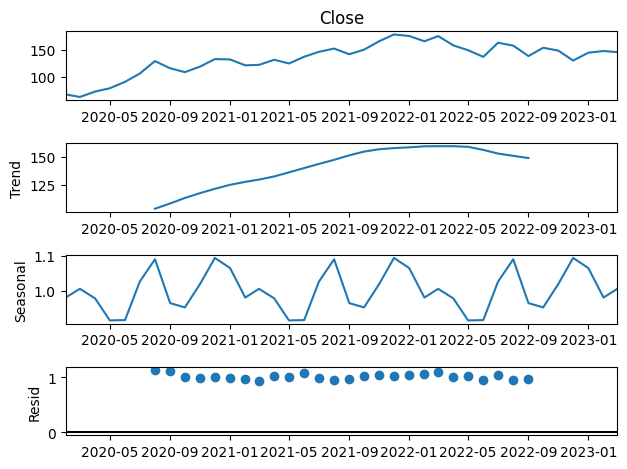

In [20]:
# Multiplicative Decomposition (y = Trend * Seasonal * Residuals)
result_mul = seasonal_decompose(df['Close'], model='multiplicative')
result_mul.plot();

❓ Choose your favorite decomposition based on the `adfuller` test

(-10.0, 15.0)

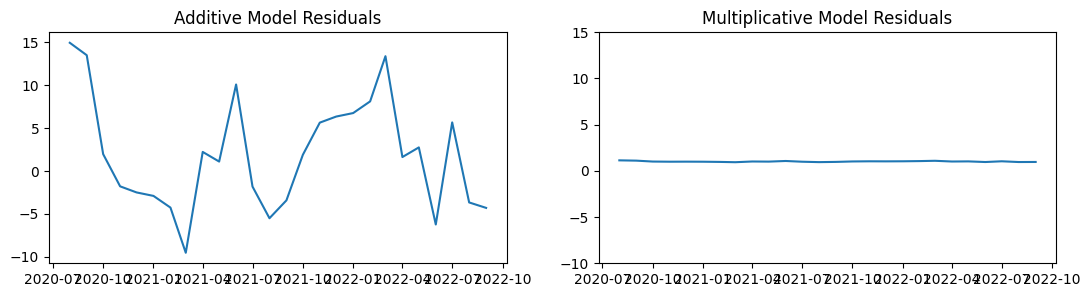

In [21]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,3))
ax1.plot(result_add.resid); ax1.set_title("Additive Model Residuals")
ax2.plot(result_mul.resid); ax2.set_title("Multiplicative Model Residuals");
plt.ylim(-10, 15)

### (1.2) Decomposition the "logarithmized" Time Series

❗️ Actually, the stock price has been growing exponentially, so we are going to work on the logarithm of the Time Series instead.

❓ Decompose the logarithmized Time Series additively and multiplicatively. Based on the `adfuller` test, which one would you choose ? 

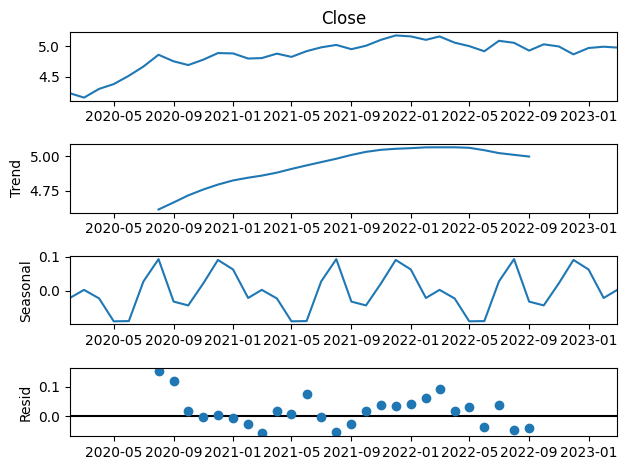

In [22]:
# Additive Decomposition (np.log(y) = Trend + Seasonal + Residuals)
result_add_log = seasonal_decompose(log_df['Close'], model='additive')
result_add_log.plot();

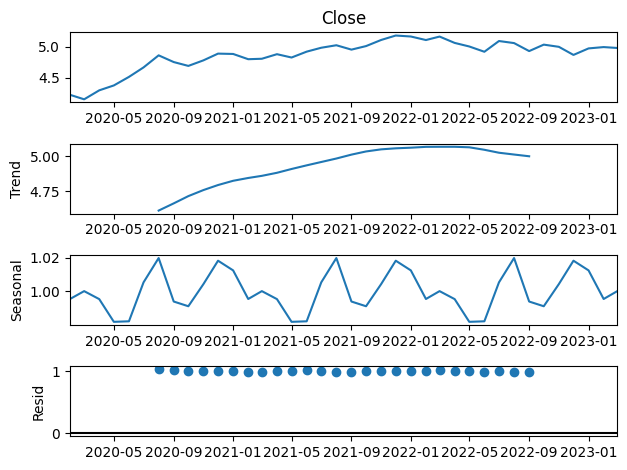

In [23]:
# Multiplicative Decomposition (np.log(y) = Trend * Seasonal * Residuals)
result_mul_log = seasonal_decompose(log_df['Close'], model='multiplicative')
result_mul_log.plot();

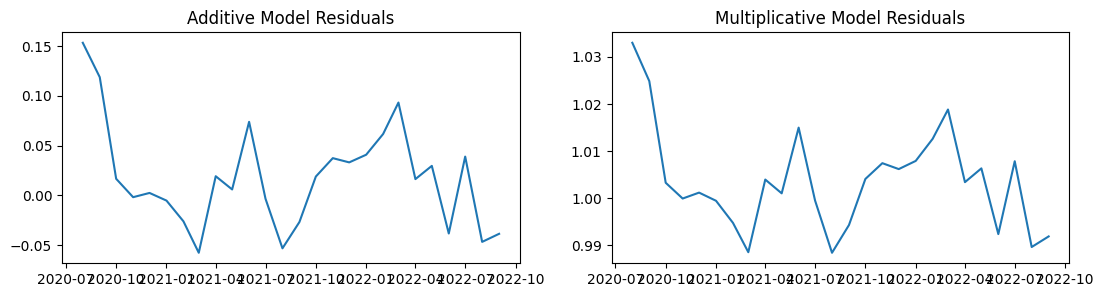

In [24]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,3))
ax1.plot(result_add_log.resid); ax1.set_title("Additive Model Residuals")
ax2.plot(result_mul_log.resid); ax2.set_title("Multiplicative Model Residuals");

In [25]:
print('additive resid: ', adfuller(result_add.resid.dropna())[1])
print('multiplicative resid: ', adfuller(result_mul.resid.dropna())[1])

additive resid:  0.19869956585540605
multiplicative resid:  0.004058862113434712


### (1.3) Remove seasonality

❓ Look at the seasonality of your Time Series. De-seasonlize your Logarithmized Time Series. Compare the latter with the non-deseasonalized Time Series. Do you detect any seasonality?

In [26]:
# Removing the multiplicative seasonal component
df['deseasonalized'] = df.Close.values/result_mul.seasonal
log_df['deseasonalized'] = log_df.Close.values/result_mul_log.seasonal

/tmp/ipykernel_1369/1838870287.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df['deseasonalized'] = log_df.Close.values/result_mul_log.seasonal


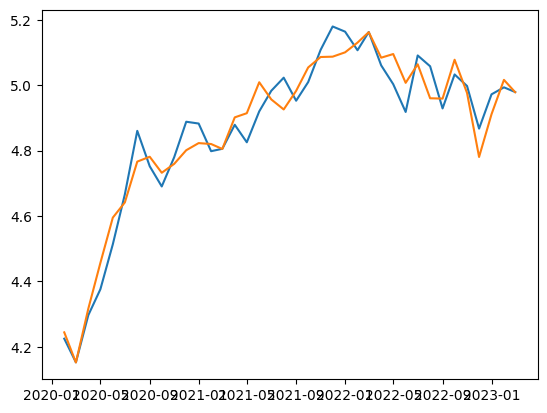

In [27]:
# Having a look at the deseasonalized LogClose vs the LogClose
plt.plot(log_df['Close'])
plt.plot(log_df['deseasonalized'])

👆 Our intuition is confirmed, there is no seasonality in the historic values of the `AAPL` stock price. But we can still work with the deseasonalized version and re-introduce it during the forecasts.

## (2) STATIONARITY / DIFFERENCING

❓ Differentiate your logarithmized TS once , twice, thrice.

* Try to determine *d* visually
* Then use `nbdiffs` from `pmdarima.arima.utils` to confirm your intuition

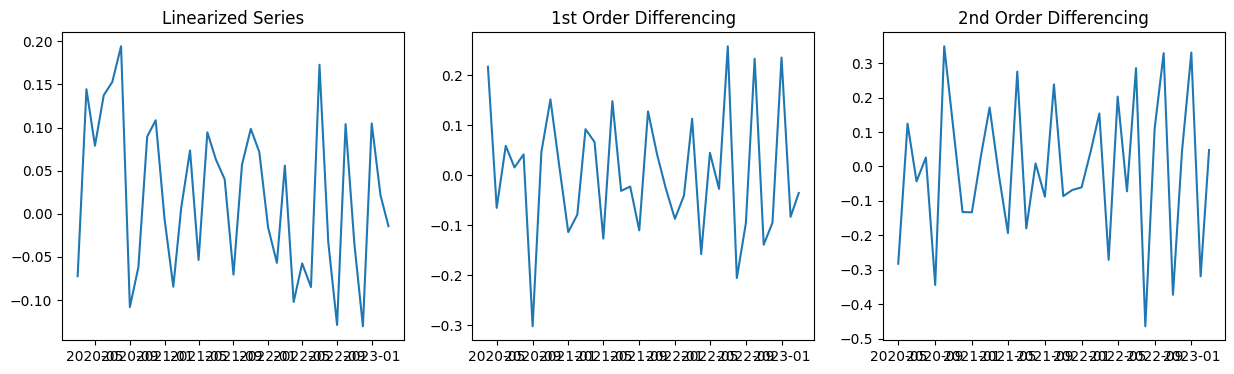

In [28]:
# Let's difference this and look at the ACFs
fig, axes = plt.subplots(1, 3,figsize=(15,4))

y_diff = log_df['Close'].diff().dropna()
axes[0].plot(y_diff); axes[0].set_title('Linearized Series')
# 1st Differencing
y_diff_diff = log_df['Close'].diff().diff().dropna()
axes[1].plot(y_diff_diff); axes[1].set_title('1st Order Differencing')

# 2nd Differencing
y_diff_diff_diff = log_df['Close'].diff().diff().diff().dropna()
axes[2].plot(y_diff_diff_diff); axes[2].set_title('2nd Order Differencing');

In [29]:
from pmdarima.arima import ndiffs
ndiffs(log_df['Close'])

1

👆 Diffencing $\color{green}{d=1}$ should be enough!

## (3) <font color="blue">ACF</font> and <font color="red">PACF</font>

❓ Plot `pacf` (partial autocorrelation function) and `acf` (autocorrelation function)

In [30]:
# LAGS MUST BE LOWER THAN 50% OF THE LEN(DF)
# Use this number of lags for your plots
lags = int(len(df)/3)
lags

12

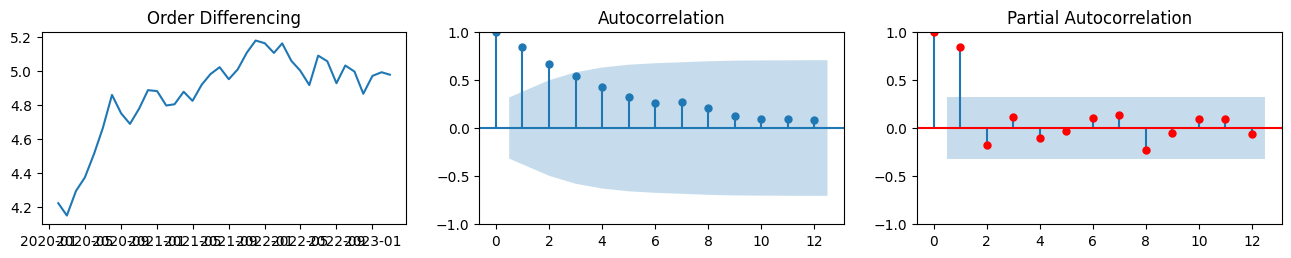

In [57]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
fig, axes = plt.subplots(1,3, figsize=(16,2.5))
axes[0].plot(log_df['Close']); axes[0].set_title('Order Differencing')
plot_acf(log_df['Close'], ax=axes[1], lags = lags);
plot_pacf(log_df['Close'], ax=axes[2], c='r', lags=lags, method='ywm');

❓ For the 1-differenced logarithmized Time Series, plot `pacf` (partial autocorrelation function) and `acf` (autocorrelation function)

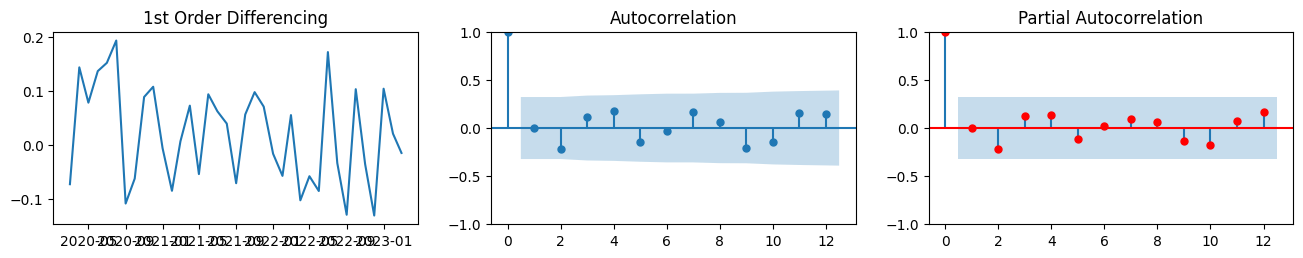

In [58]:
fig, axes = plt.subplots(1,3, figsize=(16,2.5))
axes[0].plot(y_diff); axes[0].set_title('1st Order Differencing')
plot_acf(y_diff, ax=axes[1], lags = lags);
plot_pacf(y_diff, ax=axes[2], c='r', lags=lags, method='ywm');

❓ For the 2-differenced logarithmized Time Series, plot `pacf` (partial autocorrelation function) and `acf` (autocorrelation function)

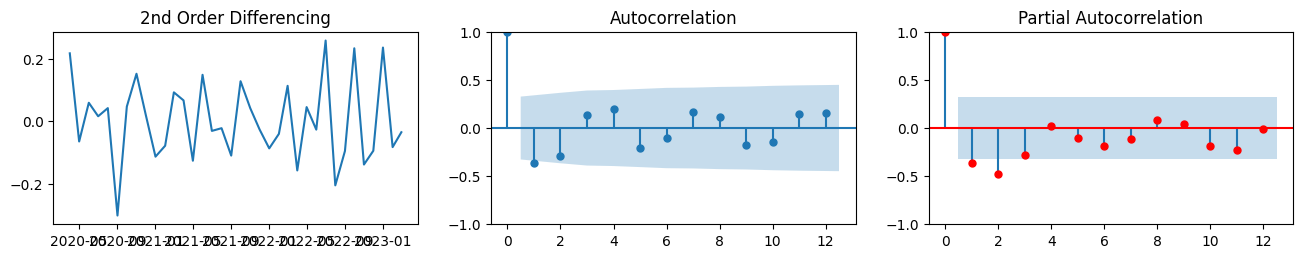

In [59]:
fig, axes = plt.subplots(1,3, figsize=(16,2.5))
axes[0].plot(y_diff_diff); axes[0].set_title('2nd Order Differencing')
plot_acf(y_diff_diff, ax=axes[1], lags = lags);
plot_pacf(y_diff_diff, ax=axes[2], c='r', lags=lags, method='ywm');

## (4) <font color="red">AR</font><font color="green">I</font><font color="blue">MA</font> MODEL

### (4.1) Choosing parameters visually

❓ Choose <font color="red">p</font>, <font color="green">d</font>, <font color="blue">q</font>

In [68]:
p = 2
d = 1
q = 1

### (4.2) Temporal <font color="blue">Train</font>-<font color="orange">Test</font> split

❓ Train Test Split your time Series chronologically.

In [69]:
index = round(train_size*log_df.shape[0])

train = log_df.iloc[:index]
test = log_df.iloc[index:]

### (4.3) <font color="blue">Training</font>

❓ Fit an ARIMA model on the train set

In [75]:
from statsmodels.tsa.arima.model import ARIMA
arima = ARIMA(train['Close'], order=(p,d,q), trend='t')
arima = arima.fit()

/home/clement/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/clement/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/clement/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


## (5) <font color="orange">FORECAST</font>

❗️ Keep in mind that we will have to revert to the "original" Time Series with two steps:
- "re-seasonalize"
- "exponentiate"

### (5.1) Forecasting future values for the  "logarithmized" and "deseasonalized" TS

❓ Forecast the future values of the logarithmized+deseasonalized Time Series

Hints:
* `forecast`
* `get_forecast`
* `predicted_mean`

Further hints (optional):
*`conf_int()`

In [76]:
forecast1 = arima.forecast(len(test), alpha=0.05)  # 95% confidence

In [77]:
forecast_results = arima.get_forecast(len(test), alpha=0.05)
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values

In [80]:
confidence_int.shape

(15, 2)

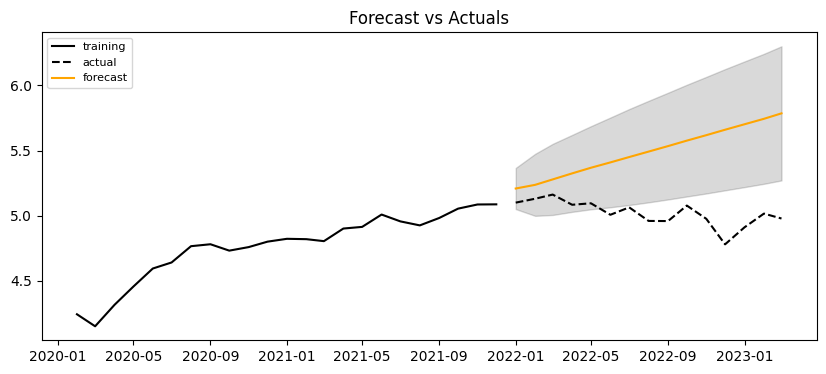

In [86]:
plot_forecast(forecast, train.iloc[:,1], test.iloc[:,1], confidence_int[:,0], confidence_int[:,1])

### (5.2) Recomposing the original Time Series and the predictions

**Wrap-up**

1. We started from `df["Close"]`
2. Applied the `logarithm` function
3. `Deseasonalized` `df["LogClose"]`

**Reconstruction steps**

Let's reverse-engineer the Time Series

1. Reseasonalize `df["LogClose"]` multiplying by `result_mult_log.seasonal`
2. Apply the `exponential function`

❓ Apply these reconstructions steps to the train set, the test set and the forecasts! (and even the upper and lower bounds of your confidence interval if you want to - *Optional*)

In [108]:
## TRAIN RECONSTRUCTED
train['reconstructed'] = np.exp(train['deseasonalized']*result_mul_log.seasonal[:index])

/tmp/ipykernel_1369/951869190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['reconstructed'] = np.exp(train['deseasonalized']*result_mul_log.seasonal[:index])


In [109]:
## TEST RECONSTRUCTED
test['reconstructed'] = np.exp(test['deseasonalized']*result_mul_log.seasonal[index:])

/tmp/ipykernel_1369/3606575266.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['reconstructed'] = np.exp(test['deseasonalized']*result_mul_log.seasonal[index:])


In [110]:
train

,Close,deseasonalized,reconstructed
Date,,,
2020-02-01,4.224495,4.243830,68.339996
2020-03-01,4.152181,4.151739,63.572498
2020-04-01,4.296605,4.316582,73.449997
2020-05-01,4.375568,4.456209,79.485001
2020-06-01,4.513055,4.594778,91.199997
2020-07-01,4.665889,4.641227,106.260002
2020-08-01,4.860122,4.766095,129.039993
2020-09-01,4.751951,4.780945,115.809998
2020-10-01,4.690063,4.731969,108.860001


In [111]:
# FORECASTED RECONSTRUCTED
forecast_recons = np.exp(forecast) * result_mul.seasonal[index:]
lower_recons = np.exp(confidence_int)[:, 0] * result_mul.seasonal[index:]
upper_recons = np.exp(confidence_int)[:, 1] * result_mul.seasonal[index:]

### (5.3) Plots

❓ Finally, use the `plot_forecast` function we gave you 🎉

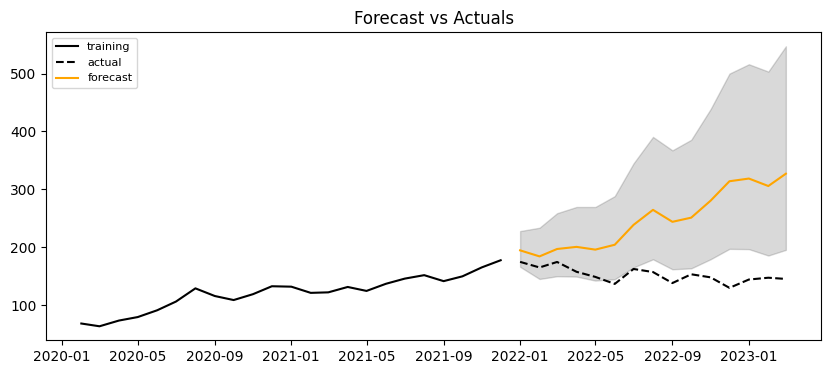

In [118]:
plot_forecast(forecast_recons, train.iloc[:,2], test.iloc[:,2], lower_recons.values, upper_recons.values)

In [113]:
lower_recons

Date
2022-01-01    166.241244
2022-02-01    145.239619
2022-03-01    149.985659
2022-04-01    149.375870
2022-05-01    142.436323
2022-06-01    144.817958
2022-07-01    165.183246
2022-08-01    179.227645
2022-09-01    161.977910
2022-10-01    163.588586
2022-11-01    179.367293
2022-12-01    197.229212
2023-01-01    196.763835
2023-02-01    185.712937
2023-03-01    195.482291
Name: seasonal, dtype: float64